In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import json

Leverage Cost of Energy: LCOE

In [4]:
# Read and convert to datetime the CSV generation files
df_P_100 = pd.read_csv("P_100.csv")
df_P_150 = pd.read_csv("P_150.csv")
df_P_PV = pd.read_csv("P_PV.csv")

df_P_100['time'] = pd.to_datetime(df_P_100['time'], utc=True)
df_P_150['time'] = pd.to_datetime(df_P_150['time'], utc=True)
df_P_PV['time'] = pd.to_datetime(df_P_PV['time'], utc=True)

def filter_on_year(df: pd.DataFrame, year: int):
    """This functions filters a dataframe on a year using the utc_timestamp column.

    Args:
        year (int): year e.g. 2017
    Return:
        df: a dataframe filter on the year parameter
    """
    return df[df['time'].dt.year == year]

sel_year= 2012

# automatize for all dataframes
df_sel_year= filter_on_year(df=df_P_100, year=sel_year)

Generation outputs are obtained from the SP335-HH100, SP335-HH150, SP277-HH100, SP277-HH150, SP199-HH100 and SP199-HH150 power curves. 
according to one of the ongoing projects of the 'LowWind Project', (Competitiviness of a low specifica power, wind speed, wind turbine ... 2050), in oder to find the costs of the generations in out locations, the specific powers of 199 to 335 have been selected, together with the hub heights 100 and 150, as these characteristics are the typical (traditional) for Europe Wind Technologies. 
Moreover, another two locations with lower average wind speeds were chosen and a low-wind-characteristics power curve has been utilized instead of the traditional curves for those simulations. The technicallities of the chosen wind turbines and farms for the simullations are the following:
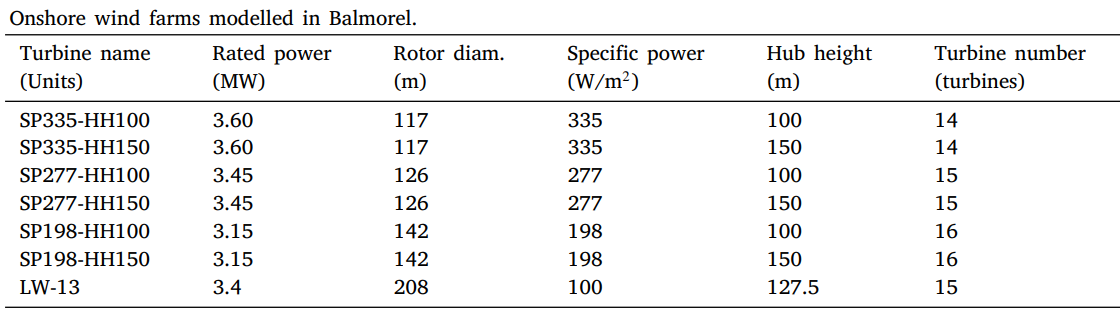
In terms of costs, the output annual hourly production is of interest (h_AEP, AEP) in order to get the LCOE, and COVE. But first, NPV needs to be obtained:

- Capex is calculated. As reference, the cost of a land wind turbine and offshore wind turbine is taken from 2021 Cost of Wind Energy Review. Compared to the 2018 paper, the onshore generator takes up 0,6862*100 of the total initial investment (Capital Expenditure). For offshore technologies, this cost represents only 33.6 % of the total Capex. Therefore, when calculating the total CAPEX of the turbine with WISDEM 

In [6]:
# COST CALCULATION
# inputs:
# capex = 92750000 #EUR

cap_inst = 50  # MW
capex = (1140000 * cap_inst)  # EUR/MW*MW
capex_wind_100= [1140000, 1250000, 1520000]*cap_inst #335-277-199
capex_wind_150= [1490000, 1600000, 1910000]*cap_inst #335-277-199
opex = 13720  # EUR/MWh

years = 25

WACC = 0.06  # A real WACC factors in inflation and is therefore lower, all other things being equal, than a nominal WACC which does not account for inflation.
OM_rate = 0.02

# procedure:
year_frac = np.array(range(years + 1))
disc_factor = [1 / ((1 + WACC) ** year_frac[i]) for i in range(years + 1)]

PVC = [capex, 0, opex]
OM_cost = opex * (1 + OM_rate)

for i in range(3, years):
    pvc_value = OM_cost * disc_factor[i]
    PVC.append(pvc_value)

NPV = sum(PVC)

loc_cost_wind = ['LOC_1', 'LOC_2', 'LOC_3', 'LOC_4.1', 'LOC_5.1', 'LOC_6', 'LOC_7', 'LOC_8.1', 'LOC_9', 'LOC_10']
LCOE_wind_100 = []

# LCOE for each location
for loc_100 in loc_cost_wind:
    # AEP
    AEP_array = np.zeros(years + 1)

    AEP = sum(np.array(df_sel_year[loc_100]) * cap_inst)
    h_AEP = np.array(df_sel_year[loc_100] * cap_inst)
    AEP_array[2:] = AEP
    PVEC = AEP_array * disc_factor
    NPVE = sum(PVEC)

    # LCOE
    LCOE = NPV / NPVE

    # Add the LCOE to LCOE_wind_100
    LCOE_wind_100.append(LCOE)

# Print the LCOE values for each location
for i in range(len(loc_cost_wind)):
    print(f"LCOE for {loc_cost_wind[i]} in gen year {sel_year}: {LCOE_wind_100[i]}")
    


LCOE for LOC_1 in gen year 2012: 43.138274155646656
LCOE for LOC_2 in gen year 2012: 31.05192857673488
LCOE for LOC_3 in gen year 2012: 39.88664047179398
LCOE for LOC_4.1 in gen year 2012: 30.153650085166124
LCOE for LOC_5.1 in gen year 2012: 23.77326796419325
LCOE for LOC_6 in gen year 2012: 33.42671587778827
LCOE for LOC_7 in gen year 2012: 27.46977259137325
LCOE for LOC_8.1 in gen year 2012: 22.32147176728977
LCOE for LOC_9 in gen year 2012: 83.12038457687049
LCOE for LOC_10 in gen year 2012: 50.294523460634025


COVE: System based required data: Load, generation wind, generation solar. 

In [1]:
# COST CALCULATION
# inputs:
cap_inst = 50  # MW
capex = (1140000 * cap_inst)  # EUR/MW*MW
capex_wind_100= [1140000, 1250000, 1520000]*cap_inst #335-277-199
capex_wind_150= [1490000, 1600000, 1910000]*cap_inst #335-277-199
opex = 13720  # EUR/MW-year

years = 25

WACC = 0.06  # A real WACC factors in inflation and is therefore lower, all other things being equal, than a nominal WACC which does not account for inflation.
OM_rate = 0.02

# procedure:
year_frac = np.array(range(years + 1))
disc_factor = [1 / ((1 + WACC) ** year_frac[i]) for i in range(years + 1)]

PVC = [capex, 0, opex]
OM_cost = opex * (1 + OM_rate)

for i in range(3, years):
    pvc_value = OM_cost * disc_factor[i]
    PVC.append(pvc_value)

NPV = sum(PVC)

loc_cost_wind = ['LOC_1', 'LOC_2', 'LOC_3', 'LOC_4.1', 'LOC_5.1', 'LOC_6', 'LOC_7', 'LOC_8.1', 'LOC_9', 'LOC_10']
# loc_cost_wind = 
COVE_wind_100 = []

# AEP_COVE
df_p_ratio_2016=pd.read_excel('p_ratios_0_1.xlsx')
# we need to fit the locations from the other file to the countries
p_ratio= df_p_ratio_2016['m_NL_0_1']

# COVE for each location
for loc_100 in loc_cost_wind:
    # AEP
    AEP_COVE_array = np.zeros(years + 1)

    h_AEP_COVE = np.array(df_sel_year[loc_100] * cap_inst)
    AEP_COVE = sum(h_AEP_COVE*p_ratio) 
    AEP_COVE_array[2:] = AEP_COVE
    COVE_PVEC = AEP_COVE_array * disc_factor
    COVE_NPVE = sum(COVE_PVEC)

    # LCOE
    COVE = NPV / (COVE_NPVE)

    # Add the LCOE to LCOE_wind_100
    COVE_wind_100.append(COVE)

# Print the LCOE values for each location
for i in range(len(loc_cost_wind)):
    print(f"COVE for {loc_cost_wind[i]}, with technology HH100 in gen year {sel_year}: {COVE_wind_100[i]}")


NameError: name 'np' is not defined